In [1]:
from keras.applications.xception import Xception
from keras.preprocessing import image
from keras.applications.xception import preprocess_input
import numpy as np
import pandas as pd
import os, cv2
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.metrics import mean_squared_error, accuracy_score, f1_score, precision_score, recall_score
from keras.layers import Input, Dense, Dropout, Flatten
from keras.models import Model, Sequential
from keras.regularizers import l1, l2
from keras.optimizers import SGD
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from IPython.display import Image
import pydotplus

Using TensorFlow backend.


In [10]:
pd.set_option('display.max_columns', None)

In [44]:
data = pd.read_csv('data_joined.csv', header=0)

In [75]:
data.head()

,parcel_name,dumping,condition,fire,improved,maintained,needs_boarding,occupancy,structure,units,use,complaint_count,crime_count,violation_count,state,photo_url,filename,newpath,dnn,label
2,17911 HAMILTON,no,good,no,NaN,NaN,no,occupied,yes,NaN,commercial,4,3,1,not_blighted,https://wdwot.s3.amazonaws.com/blexts/000/096/...,not_blighted/0.jpg,image_data/train/not_blighted/0.jpg,0.654196,1
3,20244 HARNED,no,fair,no,NaN,NaN,no,occupied,yes,1 unit,residential,0,0,0,not_blighted,https://wdwot.s3.amazonaws.com/blexts/000/242/...,not_blighted/1.jpg,image_data/train/not_blighted/1.jpg,0.688805,1
4,20550 CONLEY,no,good,no,NaN,NaN,no,occupied,yes,1 unit,residential,0,0,0,not_blighted,https://wdwot.s3.amazonaws.com/blexts/000/303/...,not_blighted/2.jpg,image_data/test/not_blighted/2.jpg,0.707509,1
5,20428 HARNED,no,good,no,NaN,NaN,no,occupied,yes,1 unit,residential,0,0,2,not_blighted,https://wdwot.s3.amazonaws.com/blexts/000/197/...,not_blighted/3.jpg,image_data/train/not_blighted/3.jpg,0.708976,1
6,2030 VINEWOOD,no,suggest demolition,yes,NaN,NaN,yes,unoccupied,yes,1 unit,residential,0,0,0,blighted,https://wdwot.s3.amazonaws.com/blexts/000/033/...,blighted/0.jpg,image_data/train/blighted/0.jpg,0.668685,0


In [4]:
os.listdir('image_data/train/')

['blighted', 'not_blighted']

In [6]:
train_blighted = ['blighted/'+fn for fn in os.listdir('image_data/train/blighted/')]
train_not_blighted = ['not_blighted/'+fn for fn in os.listdir('image_data/train/not_blighted/')]
test_blighted = ['blighted/'+fn for fn in os.listdir('image_data/test/blighted/')]
test_not_blighted = ['not_blighted/'+fn for fn in os.listdir('image_data/test/not_blighted/')]

In [7]:
def find_path(x):
    if x in train_blighted or x in train_not_blighted:
        return 'image_data/train/' + x
    if x in test_blighted or x in test_not_blighted:
        return 'image_data/test/' + x

In [49]:
data['newpath'] = data['filename'].apply(find_path)

In [11]:
model = Xception(weights='imagenet', include_top=False)

In [12]:
top_model = Sequential()
top_model.add(Flatten(input_shape=(10,10,2048)))
top_model.add(Dense(1024, activation='relu'))
top_model.add(Dropout(0.5))
top_model.add(Dense(1024, activation='relu'))
top_model.add(Dropout(0.5))
top_model.add(Dense(1, activation='sigmoid'))

In [13]:
for l in model.layers:
    l.called_with = None

In [14]:
inputs = Input(shape=(299,299,3))
x = model(inputs)
preds = top_model(x)
combined_model = Model(input=inputs, output=preds)

In [16]:
for l in combined_model.layers[1].layers:
    l.trainable = False

In [17]:
combined_model.load_weights('xception_combined_weights.h5')

In [47]:
data.dropna(subset = ['filename'], inplace = True)

In [48]:
len(data)

11627

In [50]:
dnn_predictions = []
for fp in data['newpath']:
    c1 = image.load_img(fp, target_size = (299,299))
    c1 = image.img_to_array(c1)
    c1 = np.expand_dims(c1, axis = 0)
    c1 = preprocess_input(c1)
    dnn_predictions.append(combined_model.predict(c1))

In [71]:
data['dnn'] = [x[0][0] for x in dnn_predictions]

In [74]:
data['label'] = [0 if x == 'blighted' else 1 for x in data['state']]

In [76]:
dnn_labels = [0 if x <= 0.5 else 1 for x in data['dnn']]

In [77]:
accuracy_score(data['label'].values, dnn_labels)

0.50090307043949434

In [78]:
data.to_csv('data_joined.csv', index=False)

In [79]:
datagen = image.ImageDataGenerator()

In [80]:
train_generator = datagen.flow_from_directory('image_data/train',
                                              target_size=(299,299),
                                              batch_size=32,
                                              class_mode=None,
                                              shuffle=False)

Found 9301 images belonging to 2 classes.


In [81]:
test_generator = datagen.flow_from_directory('image_data/test',
                                             target_size=(299,299),
                                             batch_size=32,
                                             class_mode=None,
                                             shuffle=False)

Found 2326 images belonging to 2 classes.


In [82]:
train_predictions = combined_model.predict_generator(train_generator, 9301)

In [87]:
train_predictions[:,0]

array([ 0.06764062,  0.00524873,  0.73066968, ...,  0.93102938,
        0.62158388,  0.95649201], dtype=float32)

In [83]:
train_filenames = train_blighted + train_not_blighted

In [84]:
len(train_filenames)

9301

In [85]:
train_labels = np.array([0]*4642 + [1]*4659)

In [88]:
train_pred_bin = [0 if x <= 0.5 else 1 for x in train_predictions[:,0]]

In [89]:
accuracy_score(train_labels, train_pred_bin)

0.80464466186431571

In [90]:
test_predictions = combined_model.predict_generator(test_generator, 2326)

In [91]:
test_filenames = test_blighted + test_not_blighted

In [92]:
len(test_filenames)

2326

In [93]:
test_labels = np.array([0]*1161 + [1]*1165)

In [110]:
test_pred_bin = [0 if x <= 0.5 else 1 for x in test_predictions[:,0]]

In [111]:
accuracy_score(test_labels, test_pred_bin)

0.79535683576956151

In [97]:
prob_df = pd.DataFrame({'prob': list(train_predictions[:,0]) + list(test_predictions[:,0]),
                        'filename': train_filenames + test_filenames})

In [98]:
prob_df.head()

,filename,prob
0,blighted/3207.jpg,0.067641
1,blighted/4101.jpg,0.005249
2,blighted/4785.jpg,0.730670
3,blighted/87.jpg,0.020685
4,blighted/4858.jpg,0.220781


In [99]:
themerge = data.merge(prob_df, on='filename')

In [2]:
themerge = pd.read_csv('data_joined_full.csv')

In [14]:
themerge.head()

,parcel_name,complaint_count,crime_count,violation_count,state,photo_url,filename,newpath,dnn,label,prob,dumping_no,dumping_yes,condition_fair,condition_good,condition_poor,condition_suggest demolition,fire_no,fire_yes,improved_improved,improved_unimproved,maintained_no,maintained_yes,needs_boarding_no,needs_boarding_yes,occupancy_maybe,occupancy_occupied,occupancy_unoccupied,structure_no,structure_yes,units_0 units,units_1 unit,units_2-3 units,units_4+ units,use_commercial,use_industrial,use_institutional,use_mixed,use_private,use_public,use_residential,use_unknown
0,17911 HAMILTON,4,3,1,not_blighted,https://wdwot.s3.amazonaws.com/blexts/000/096/...,not_blighted/0.jpg,image_data/train/not_blighted/0.jpg,0.654196,1,0.045701,1,0,0,1,0,0,1,0,0,0,0,0,1,0,0,1,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0
1,20244 HARNED,0,0,0,not_blighted,https://wdwot.s3.amazonaws.com/blexts/000/242/...,not_blighted/1.jpg,image_data/train/not_blighted/1.jpg,0.688805,1,0.876882,1,0,1,0,0,0,1,0,0,0,0,0,1,0,0,1,0,0,1,0,1,0,0,0,0,0,0,0,0,1,0
2,20550 CONLEY,0,0,0,not_blighted,https://wdwot.s3.amazonaws.com/blexts/000/303/...,not_blighted/2.jpg,image_data/test/not_blighted/2.jpg,0.707509,1,0.453202,1,0,0,1,0,0,1,0,0,0,0,0,1,0,0,1,0,0,1,0,1,0,0,0,0,0,0,0,0,1,0
3,20428 HARNED,0,0,2,not_blighted,https://wdwot.s3.amazonaws.com/blexts/000/197/...,not_blighted/3.jpg,image_data/train/not_blighted/3.jpg,0.708976,1,0.773489,1,0,0,1,0,0,1,0,0,0,0,0,1,0,0,1,0,0,1,0,1,0,0,0,0,0,0,0,0,1,0
4,2030 VINEWOOD,0,0,0,blighted,https://wdwot.s3.amazonaws.com/blexts/000/033/...,blighted/0.jpg,image_data/train/blighted/0.jpg,0.668685,0,0.099240,1,0,0,0,0,1,0,1,0,0,0,0,0,1,0,0,1,0,1,0,1,0,0,0,0,0,0,0,0,1,0


In [113]:
X = themerge[['complaint_count', 'crime_count', 'violation_count', 'prob']]

In [6]:
y = themerge['label']

In [115]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [154]:
dtc_model = DecisionTreeClassifier(max_depth=5, random_state=42)

In [155]:
dtc_model.fit(X_train, y_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=5,
            max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=42, splitter='best')

In [156]:
dtc_pred = dtc_model.predict(X_test)

In [157]:
accuracy_score(y_test, dtc_pred)

0.80610490111779876

In [158]:
y_pred = [0 if x <= 0.5 else 1 for x in X_test['prob']]

In [159]:
accuracy_score(y_test, y_pred)

0.78933791917454854

In [160]:
themerge.to_csv('data_joined_full.csv', index=None)

In [12]:
cols = [c for c in themerge.columns if not c in ['parcel_name', 'complaint_count', 'crime_count', 'violation_count', 'state', 'photo_url', 'filename', 'newpath', 'dnn', 'label', 'prob']]

In [13]:
themerge = pd.get_dummies(themerge, columns=cols)

In [16]:
cols1 = [c for c in themerge.columns if not c in ['parcel_name', 'state', 'photo_url', 'filename', 'newpath', 'dnn', 'label', 'condition_suggest demolition']]

In [17]:
X = themerge[cols1]

In [18]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [168]:
dtc_full = DecisionTreeClassifier(max_depth=1, random_state=42)

In [169]:
dtc_full.fit(X_train, y_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=1,
            max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=42, splitter='best')

In [170]:
y_pred = dtc_full.predict(X_test)

In [171]:
accuracy_score(y_test, y_pred)

0.89036973344797932

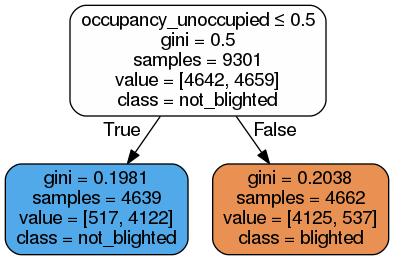

In [177]:
dot_data = export_graphviz(dtc_full, out_file=None, rotate=False, feature_names=cols1, class_names=['blighted', 'not_blighted'], filled=True, rounded=True, special_characters=True)
graph = pydotplus.graph_from_dot_data(dot_data)
Image(graph.create_png())

In [178]:
dtc_full2 = DecisionTreeClassifier(max_depth=2, random_state=42)

In [179]:
dtc_full2.fit(X_train, y_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=2,
            max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=42, splitter='best')

In [180]:
y_pred2 = dtc_full2.predict(X_test)

In [181]:
accuracy_score(y_test, y_pred2)

0.89939810834049871

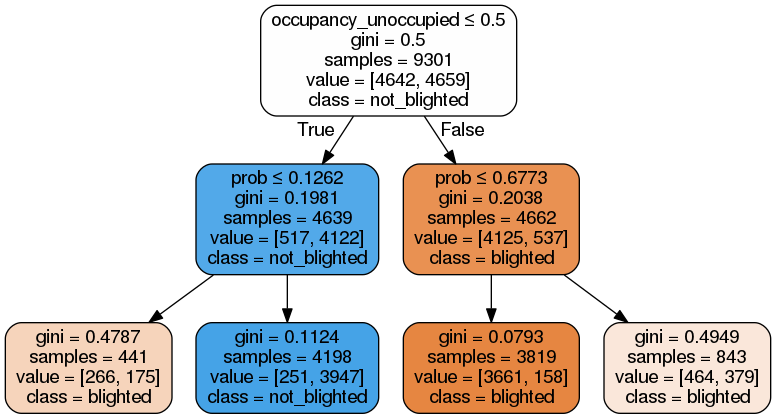

In [182]:
dot_data = export_graphviz(dtc_full2, out_file=None, rotate=False, feature_names=cols1, class_names=['blighted', 'not_blighted'], filled=True, rounded=True, special_characters=True)
graph = pydotplus.graph_from_dot_data(dot_data)
Image(graph.create_png())

In [19]:
dtc_fulln = DecisionTreeClassifier(max_depth=6, random_state=42)

In [20]:
dtc_fulln.fit(X_train, y_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=6,
            max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=42, splitter='best')

In [21]:
y_predn = dtc_fulln.predict(X_test)

In [22]:
accuracy_score(y_test, y_predn)

0.94110060189165945

In [24]:
precision_score(y_test, y_predn)

0.93633276740237692

In [25]:
recall_score(y_test, y_predn)

0.94678111587982827

In [26]:
f1_score(y_test, y_predn)

0.94152795561246272

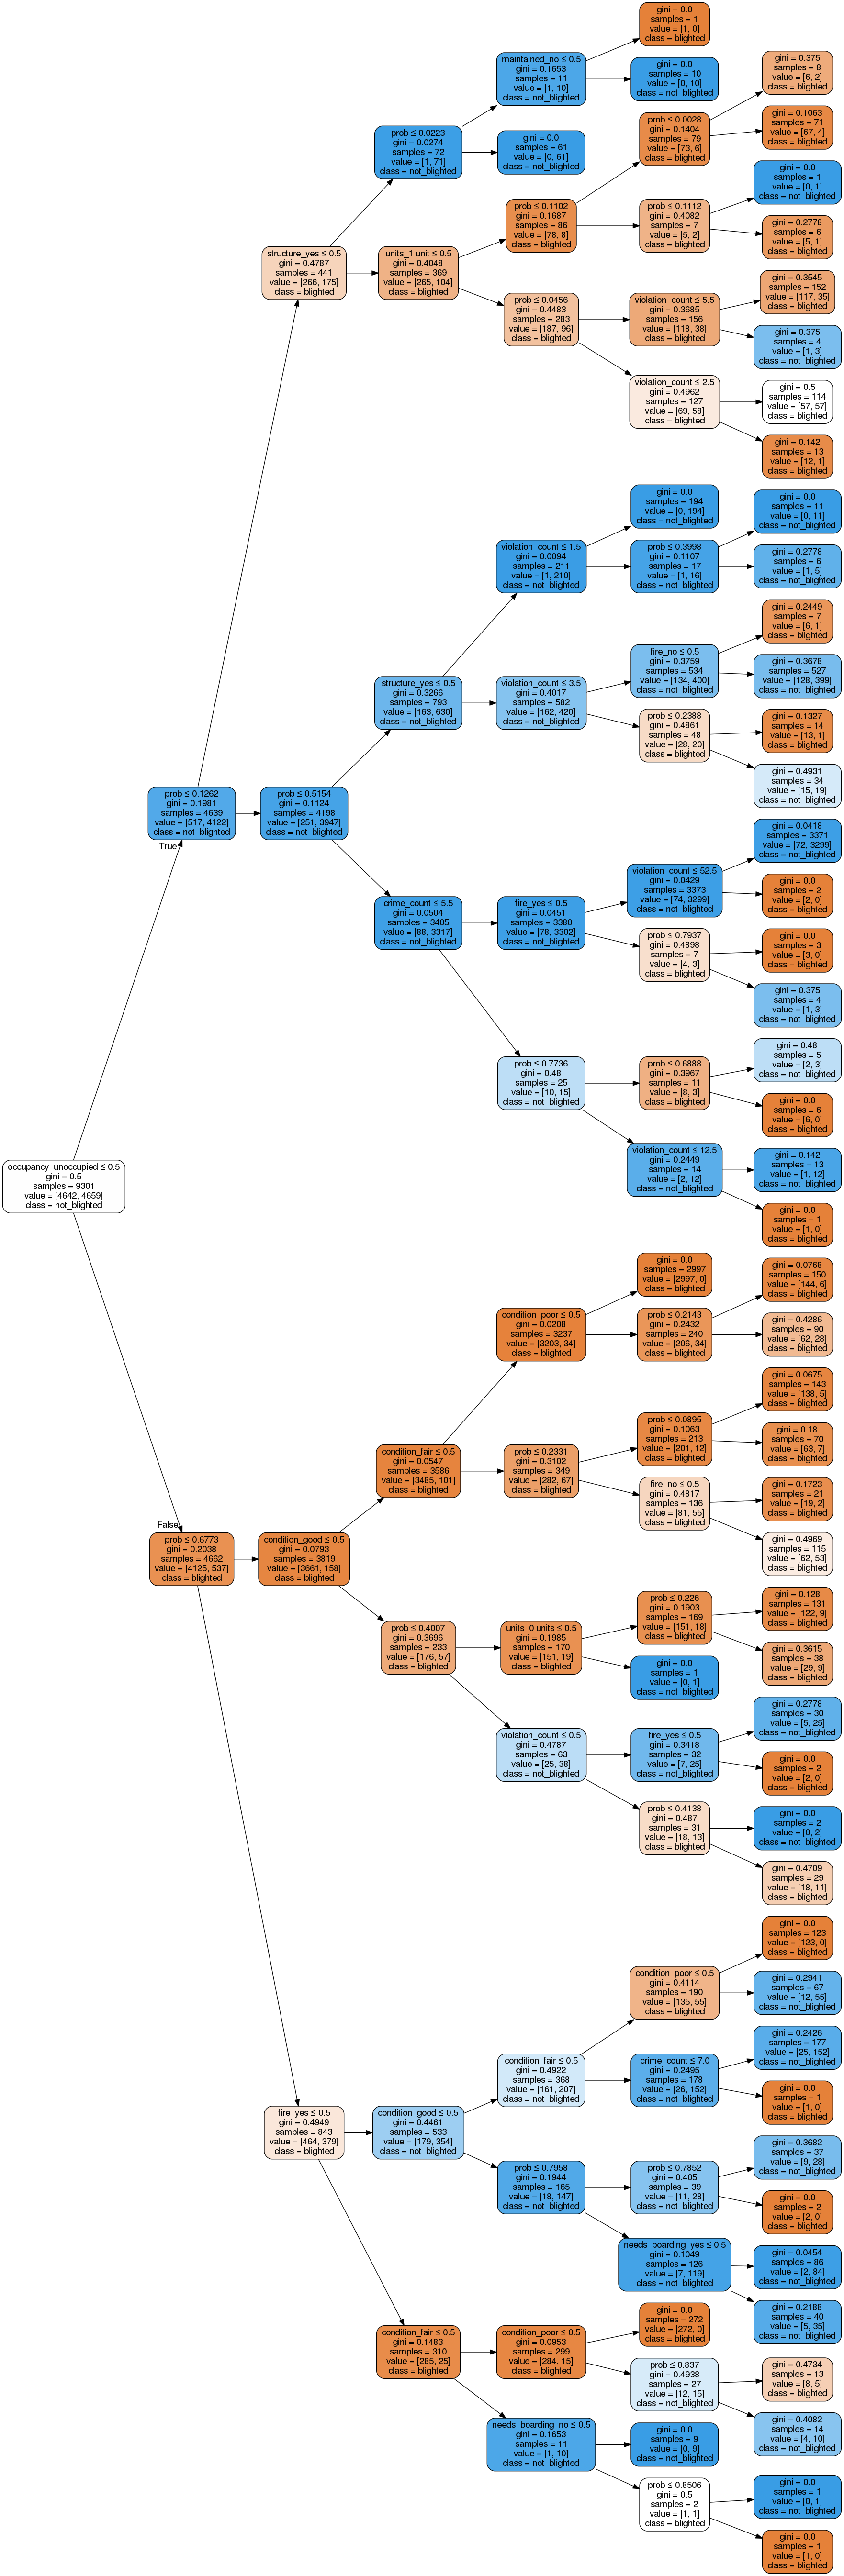

In [23]:
dot_data = export_graphviz(dtc_fulln, out_file=None, rotate=True, feature_names=cols1, class_names=['blighted', 'not_blighted'], filled=True, rounded=True, special_characters=True)
graph = pydotplus.graph_from_dot_data(dot_data)
Image(graph.create_png())

/home/cathyw/miniconda3/lib/python3.5/site-packages/ipykernel/__main__.py:2: RuntimeWarning: divide by zero encountered in log
  from ipykernel import kernelapp as app


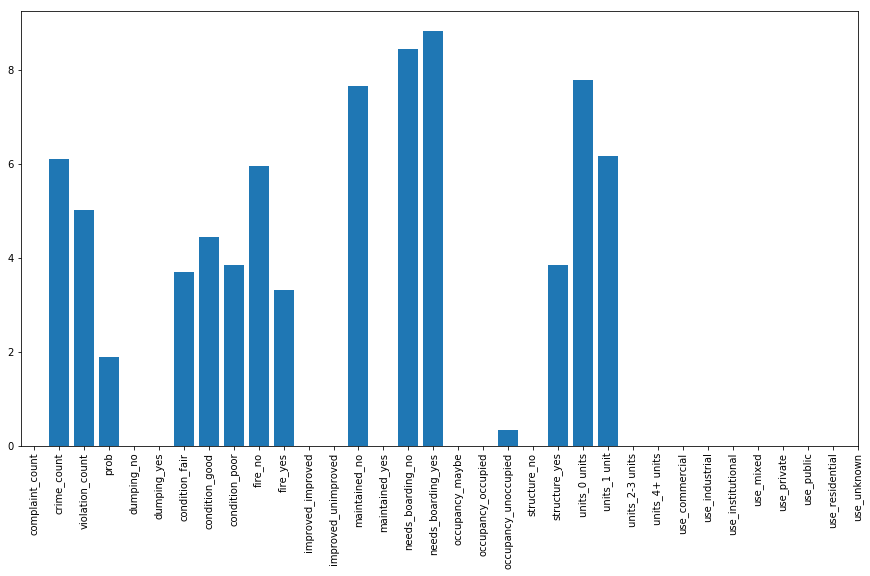

In [212]:
plt.figure(figsize=(15,8))
plt.bar(np.arange(len(dtc_fulln.feature_importances_)), np.abs(np.log(dtc_fulln.feature_importances_)))
plt.xticks(np.arange(len(dtc_fulln.feature_importances_)), cols1, rotation='vertical')
plt.show()

In [226]:
themerge[(themerge['state'] == 'blighted') & (themerge['prob'] > 0.9) & (themerge['condition_good'] == 1)]

,parcel_name,complaint_count,crime_count,violation_count,state,photo_url,filename,newpath,dnn,label,prob,dumping_no,dumping_yes,condition_fair,condition_good,condition_poor,condition_suggest demolition,fire_no,fire_yes,improved_improved,improved_unimproved,maintained_no,maintained_yes,needs_boarding_no,needs_boarding_yes,occupancy_maybe,occupancy_occupied,occupancy_unoccupied,structure_no,structure_yes,units_0 units,units_1 unit,units_2-3 units,units_4+ units,use_commercial,use_industrial,use_institutional,use_mixed,use_private,use_public,use_residential,use_unknown
1607,7643 DEXTER,0,0,0,blighted,https://wdwot.s3.amazonaws.com/blexts/000/413/...,blighted/796.jpg,image_data/test/blighted/796.jpg,0.654105,0,0.951141,1,0,0,1,0,0,1,0,0,0,0,0,1,0,0,1,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0
2977,9390 GOETHE,0,0,5,blighted,https://wdwot.s3.amazonaws.com/blexts/000/168/...,blighted/1551.jpg,image_data/test/blighted/1551.jpg,0.697714,0,0.954647,1,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,1,0,1,0,1,0,0,0,0,0,0,0,0,1,0
3199,9171 W FORT,1,0,0,blighted,https://wdwot.s3.amazonaws.com/blexts/000/094/...,blighted/1704.jpg,image_data/train/blighted/1704.jpg,0.651750,0,0.963537,1,0,0,1,0,0,1,0,0,0,0,0,1,0,0,1,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0
3423,14400 E WARREN,0,6,0,blighted,https://wdwot.s3.amazonaws.com/blexts/000/081/...,blighted/1815.jpg,image_data/train/blighted/1815.jpg,0.656508,0,0.974751,1,0,0,1,0,0,1,0,0,0,0,0,1,0,0,1,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0
4314,5903 BUCKINGHAM,0,1,0,blighted,https://wdwot.s3.amazonaws.com/blexts/000/102/...,blighted/2304.jpg,image_data/train/blighted/2304.jpg,0.706855,0,0.925011,1,0,0,1,0,0,1,0,0,0,0,0,1,0,0,0,1,0,1,0,1,0,0,0,0,0,0,0,0,1,0
4317,5543 BUCKINGHAM,0,1,0,blighted,https://wdwot.s3.amazonaws.com/blexts/000/100/...,blighted/2306.jpg,image_data/train/blighted/2306.jpg,0.681862,0,0.927108,1,0,0,1,0,0,1,0,0,0,0,0,1,0,0,1,0,0,1,0,1,0,0,0,0,0,0,0,0,1,0
5030,7819 LONGACRE,0,0,0,blighted,https://wdwot.s3.amazonaws.com/blexts/000/168/...,blighted/2557.jpg,image_data/test/blighted/2557.jpg,0.708595,0,0.940969,1,0,0,1,0,0,1,0,0,0,0,0,1,0,1,0,0,0,1,0,1,0,0,0,0,0,0,0,0,1,0
5072,19418 ASHTON,0,0,0,blighted,https://wdwot.s3.amazonaws.com/blexts/000/221/...,blighted/2576.jpg,image_data/train/blighted/2576.jpg,0.679220,0,0.920220,1,0,0,1,0,0,1,0,0,0,0,0,1,0,0,1,0,0,1,0,1,0,0,0,0,0,0,0,0,1,0
5124,7354 BRACE,0,0,0,blighted,https://wdwot.s3.amazonaws.com/blexts/000/172/...,blighted/2592.jpg,image_data/train/blighted/2592.jpg,0.700143,0,0.917052,1,0,0,1,0,0,1,0,0,0,0,0,1,0,0,1,0,0,1,0,1,0,0,0,0,0,0,0,0,1,0
5329,17150 VAUGHAN,0,0,0,blighted,https://wdwot.s3.amazonaws.com/blexts/000/014/...,blighted/2661.jpg,image_data/train/blighted/2661.jpg,0.719593,0,0.955580,1,0,0,1,0,0,1,0,0,0,0,0,1,0,1,0,0,0,1,0,1,0,0,0,0,0,0,0,0,1,0


In [221]:
themerge[themerge['filename'] == 'blighted/28.jpg']

,parcel_name,complaint_count,crime_count,violation_count,state,photo_url,filename,newpath,dnn,label,prob,dumping_no,dumping_yes,condition_fair,condition_good,condition_poor,condition_suggest demolition,fire_no,fire_yes,improved_improved,improved_unimproved,maintained_no,maintained_yes,needs_boarding_no,needs_boarding_yes,occupancy_maybe,occupancy_occupied,occupancy_unoccupied,structure_no,structure_yes,units_0 units,units_1 unit,units_2-3 units,units_4+ units,use_commercial,use_industrial,use_institutional,use_mixed,use_private,use_public,use_residential,use_unknown
68,260 FORTUNE,0,0,0,blighted,https://wdwot.s3.amazonaws.com/blexts/000/088/...,blighted/28.jpg,image_data/train/blighted/28.jpg,0.762034,0,0.002691,1,0,0,0,0,1,0,1,0,0,0,0,1,0,0,0,1,0,1,0,0,1,0,0,0,0,0,0,0,1,0
